In [ ]:
# Run some setup code for this notebook.

import random
import numpy as np
import matplotlib.pyplot as plt
import os


from __future__ import print_function

from builtins import range
from six.moves import cPickle as pickle
from imageio import imread
import platform

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Download the dataset
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2021-02-05 20:40:20--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  98.0MB/s    in 1.7s    

2021-02-05 20:40:22 (98.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# This cell loads the training and testing dataset. Please note the variables at
# the end of the cell as you would require them to access the train/test data 
# and labels throughout the assignment
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))
  
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


cifar10_dir = 'cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


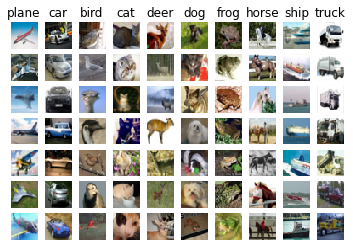

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
# You will keep coming back to this cell to add more functions as and when
# required. Right now it is very simple!
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass
    def train(self,x,y):
      self.X_train=x
      self.y_train=y
    def compute_distances_no_loop(self,X):
      num_test = X.shape[0]
      num_train = self.X_train.shape[0]
      dists = np.zeros((num_test, num_train))
      dists = np.sqrt((X**2).sum(axis=1)[:, np.newaxis] + (self.X_train**2).sum(axis=1) - 2 * X.dot(self.X_train.T))
      return dists
    def compute_distances_one_loop(self, X):
      num_test = X.shape[0]
      num_train = self.X_train.shape[0]
      dists = np.zeros((num_test, num_train))
      for i in range(num_test):
          dists[i, :] = np.sum((self.X_train - X[i, :])**2, axis=1)
      return dists
    def compute_distances_two_loops(self,x):
      dists=[]
      for i in range(len(x)):
        dists.append([])
        for j in range(len(self.X_train)):
          #dists[i].append(np.linalg.norm(X_train[j]-X_test[i]))
          x1=np.subtract(X_train[j],x[i])
          x2=x1.dot(x1)
          x1=np.sqrt(x2)
          dists[i].append(x1)
      return np.array(dists)
    def predict_labels(self,dists,k):
      y_pred=[]
      for j in range(0,len(dists)): 
        dist_Eu=[]
        for i in range(0,len(dists[0])):
          dist_Eu.append([self.y_train[i],dists[j][i]])
        dist_Eu1 = sorted(dist_Eu, key=lambda x: x[1])
        dict={}
        for i in range(0,k):
          if dist_Eu1[i][0] not in dict:
            dict[dist_Eu1[i][0]]=1
          else:
            dict[dist_Eu1[i][0]]+=1
        max=-1
        ans=""
        for ele in dict:
          if dict[ele]>max:
            max=dict[ele]
            ans=ele
        y_pred.append(ans)
      return y_pred
      

In [ ]:
# Make sure to add train() in the classifier class before executing this cell
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [ ]:
# Make sure to add compute_distances_two_loops() in the classifier class 
# before executing this cell
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


In [ ]:
# Make sure to add predict_labels() in the classifier class 
# before executing this cell
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [ ]:
# Use this cell to compute accuracies for k = 3, 5, 7
y_test_pred = classifier.predict_labels(dists, k=3)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
y_test_pred = classifier.predict_labels(dists, k=5)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))
y_test_pred = classifier.predict_labels(dists, k=7)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))


Got 140 / 500 correct => accuracy: 0.280000
Got 145 / 500 correct => accuracy: 0.290000
Got 146 / 500 correct => accuracy: 0.292000


In [ ]:
import time

In [ ]:
# Use this cell to call the functions
st=time.time()
dists = classifier.compute_distances_two_loops(X_test)
print("Two loops time:",time.time()-st)
st=time.time()
dists = classifier.compute_distances_one_loop(X_test)
print("one loop time:",time.time()-st)
st=time.time()
dists = classifier.compute_distances_no_loop(X_test)
print("No loop time:",time.time()-st)

Two loops time: 19.557968616485596
one loop time: 30.382253408432007
No loop time: 0.5773725509643555


In [ ]:
# Use this cell to present your timing results for computing distance matrix

In [ ]:
# Use this cell to implement Cross Validation